In [1]:
import mne
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  LSTM,  TimeDistributed
from sklearn.model_selection import train_test_split



In [37]:
filepath = 'C:\ImaginationPerceptionDataset\DataSet\perceptionImaginationEEG\preprocessed\sub-03\ses-03\eeg\sub3_sess3_50_ica_eeg.fif'
data = mne.io.read_raw_fif(filepath, preload=True, verbose=False)
events = mne.events_from_annotations(data)
eventId = {f'Imagination': list(range(1, 101)), f'Perception': list(range(101, 200))}

Used Annotations descriptions: ['0, Imagination_a_flower_high_10###my_stream_name', '0, Imagination_a_flower_high_11###my_stream_name', '0, Imagination_a_flower_high_17###my_stream_name', '0, Imagination_a_flower_high_23###my_stream_name', '0, Imagination_a_flower_high_4###my_stream_name', '0, Imagination_a_flower_high_5###my_stream_name', '0, Imagination_a_flower_low_10###my_stream_name', '0, Imagination_a_flower_low_13###my_stream_name', '0, Imagination_a_flower_low_17###my_stream_name', '0, Imagination_a_flower_low_23###my_stream_name', '0, Imagination_a_flower_low_25###my_stream_name', '0, Imagination_a_flower_low_5###my_stream_name', '0, Imagination_a_flower_normal_10###my_stream_name', '0, Imagination_a_flower_normal_11###my_stream_name', '0, Imagination_a_flower_normal_12###my_stream_name', '0, Imagination_a_flower_normal_16###my_stream_name', '0, Imagination_a_flower_normal_17###my_stream_name', '0, Imagination_a_flower_normal_19###my_stream_name', '0, Imagination_a_flower_norm

In [38]:
def cleanEvents(events):
    cleanedEvents = []
    ignoreEvents = [100, 200, 201]
    for event in events[0]:
        if event[2] in ignoreEvents:
            continue
        else:
            cleanedEvents.append(event)
    cleanedEvents = np.array(cleanedEvents)
    return cleanedEvents

def perceptionAndImaginationEvents(events): 
    cleanedEvents = cleanEvents(events)
    perceptionKeys = []
    imaginationKeys = []
    for item, key in events[1].items():
        if 'Perception' in item:
            perceptionKeys.append(key)
        if 'Imagination' in item:
            imaginationKeys.append(key)

    for index in range(cleanedEvents.shape[0]):
        key = cleanedEvents[index][2]
        if key in perceptionKeys:
            cleanedEvents[index][2] = 1
        elif key in imaginationKeys:
            cleanedEvents[index][2] = 2

    return cleanedEvents
    


In [44]:
events = mne.events_from_annotations(data)
cleanedEvents = perceptionAndImaginationEvents(events)
newEventId = {'Perception':1, 'Imagination':2}
epochs = mne.Epochs(data.copy(), cleanedEvents, event_id=newEventId, tmin=-0.2, tmax=1.0, preload=True)
perception = epochs['Perception'].get_data()
imagination = epochs['Imagination'].get_data()
perception.shape, imagination.shape

Used Annotations descriptions: ['0, Imagination_a_flower_high_10###my_stream_name', '0, Imagination_a_flower_high_11###my_stream_name', '0, Imagination_a_flower_high_17###my_stream_name', '0, Imagination_a_flower_high_23###my_stream_name', '0, Imagination_a_flower_high_4###my_stream_name', '0, Imagination_a_flower_high_5###my_stream_name', '0, Imagination_a_flower_low_10###my_stream_name', '0, Imagination_a_flower_low_13###my_stream_name', '0, Imagination_a_flower_low_17###my_stream_name', '0, Imagination_a_flower_low_23###my_stream_name', '0, Imagination_a_flower_low_25###my_stream_name', '0, Imagination_a_flower_low_5###my_stream_name', '0, Imagination_a_flower_normal_10###my_stream_name', '0, Imagination_a_flower_normal_11###my_stream_name', '0, Imagination_a_flower_normal_12###my_stream_name', '0, Imagination_a_flower_normal_16###my_stream_name', '0, Imagination_a_flower_normal_17###my_stream_name', '0, Imagination_a_flower_normal_19###my_stream_name', '0, Imagination_a_flower_norm

Not setting metadata
900 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 900 events and 1230 original time points ...
0 bad epochs dropped


C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_12308\1655157183.py:5: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  perception = epochs['Perception'].get_data()
C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_12308\1655157183.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  imagination = epochs['Imagination'].get_data()


((450, 124, 1230), (450, 124, 1230))

In [69]:
erpPerception = epochs['Perception'].average()
erpImagination = epochs['Imagination'].average()
erpDifference = mne.combine_evoked([erpPerception, erpImagination], weights=[1, -1])

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
evoked = epochs.average()
dataEvoked = evoked.data
dataEvoked.shape

(124, 1230)

In [79]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_12308\3994902189.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


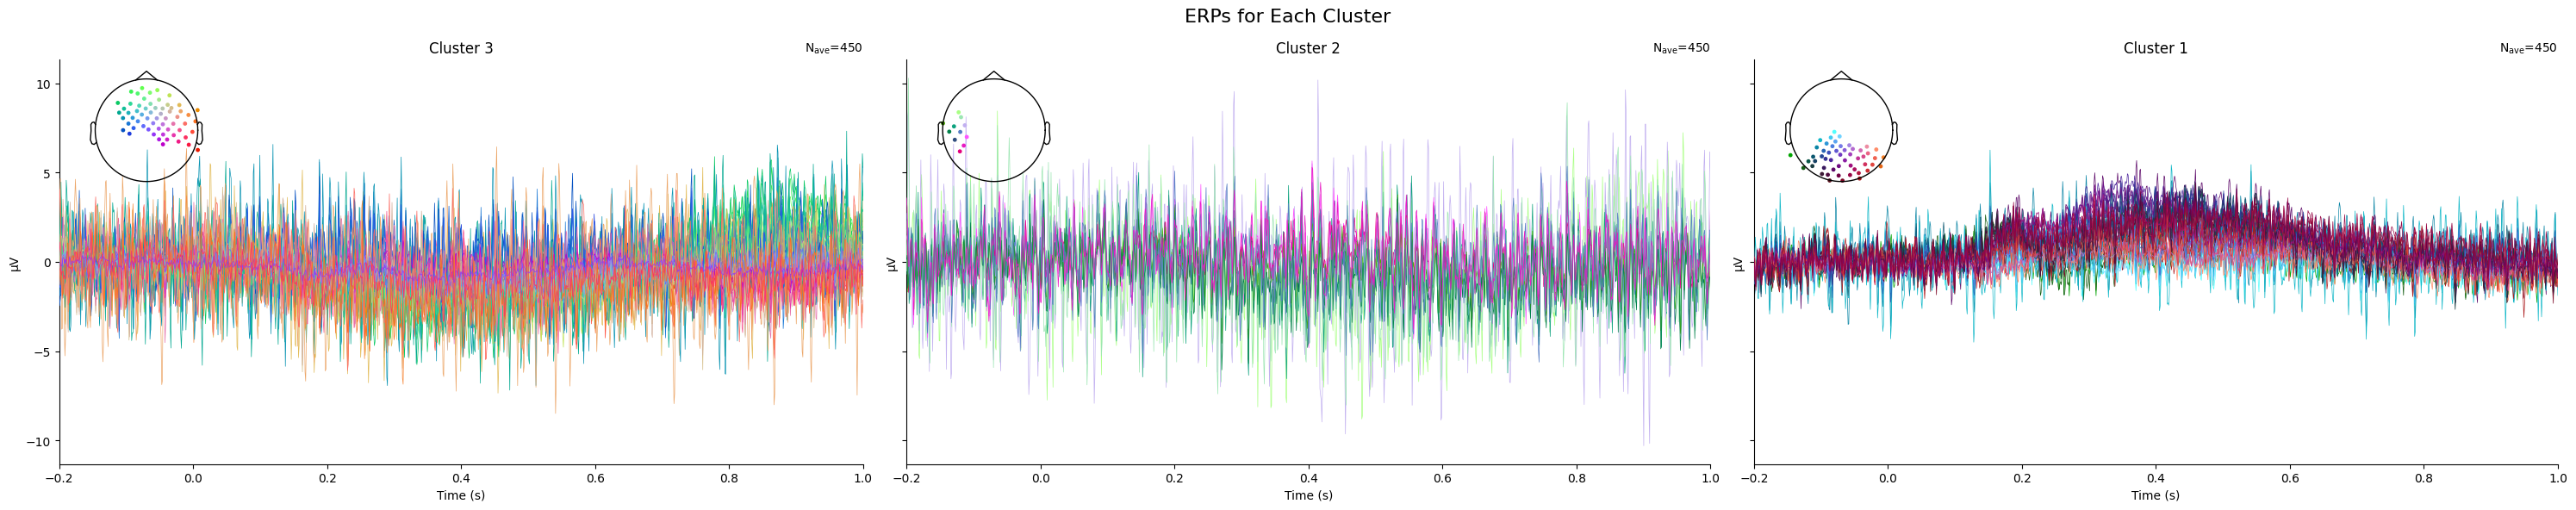

In [78]:


evoked = epochs['Perception']
evoked = evoked.average()
dataEvoked = evoked.data  

Z = linkage(dataEvoked, method='ward')
num_clusters = 3

cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
clusters = {}
for i, label in enumerate(cluster_labels):
    clusters.setdefault(label, []).append(epochs.ch_names[i])

fig, axes = plt.subplots(1, num_clusters, figsize=(30, 6), sharex=True, sharey=True)

for cluster_idx, (cluster, channels) in enumerate(clusters.items()):
    evoked_cluster = evoked.copy().pick(channels)

    ax = axes[cluster_idx]
    evoked_cluster.plot(axes=ax, show=False, time_unit='s')  

    ax.set_title(f"Cluster {cluster}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

fig.suptitle('ERPs for Each Cluster', fontsize=16)
plt.tight_layout()
plt.show()


C:\Users\Owais Mujtaba\AppData\Local\Temp\ipykernel_12308\3437841327.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


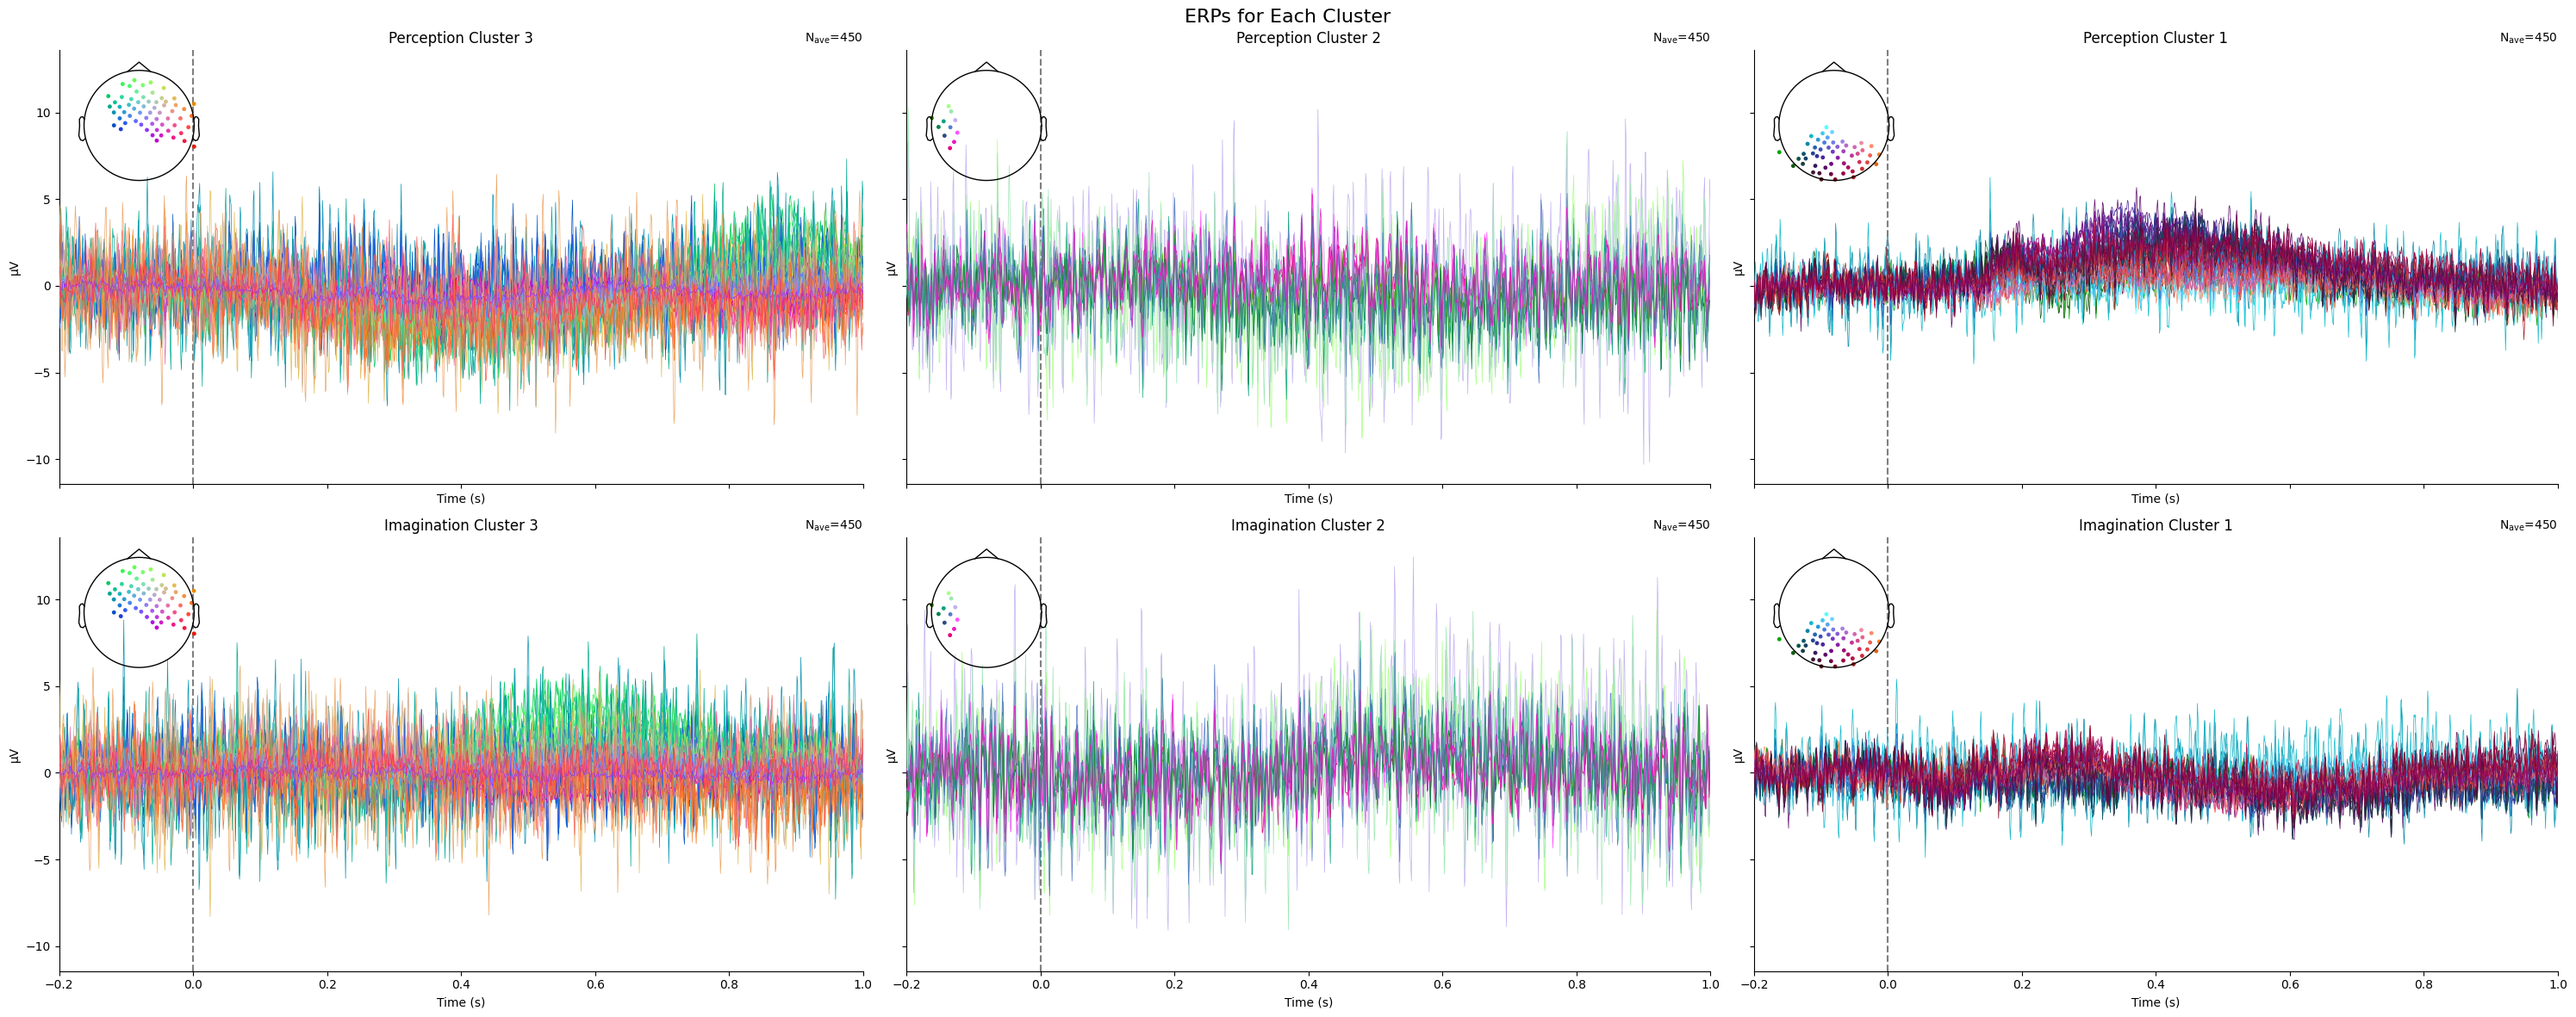

In [82]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from mne import Epochs


evoked_perception = epochs['Perception'].average()
data_evoked_perception = evoked_perception.data  

Z_perception = linkage(data_evoked_perception, method='ward')
num_clusters = 3

cluster_labels_perception = fcluster(Z_perception, num_clusters, criterion='maxclust')
clusters_perception = {}
for i, label in enumerate(cluster_labels_perception):
    clusters_perception.setdefault(label, []).append(epochs.ch_names[i])

evoked_imagination = epochs['Imagination'].average()
data_evoked_imagination = evoked_imagination.data  

Z_imagination = linkage(data_evoked_imagination, method='ward')

cluster_labels_imagination = fcluster(Z_imagination, num_clusters, criterion='maxclust')
clusters_imagination = {}
for i, label in enumerate(cluster_labels_imagination):
    clusters_imagination.setdefault(label, []).append(epochs.ch_names[i])

fig, axes = plt.subplots(2, num_clusters, figsize=(30, 12), sharex=True, sharey=True)

for cluster_idx, (cluster, channels) in enumerate(clusters_perception.items()):
    evoked_cluster = evoked_perception.copy().pick(channels)

    ax = axes[0, cluster_idx]
    evoked_cluster.plot(axes=ax, show=False, time_unit='s')  

    ax.set_title(f"Perception Cluster {cluster}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=0, color='gray', linestyle='--')

for cluster_idx, (cluster, channels) in enumerate(clusters_perception.items()):
    evoked_cluster = evoked_imagination.copy().pick(channels)

    ax = axes[1, cluster_idx]
    evoked_cluster.plot(axes=ax, show=False, time_unit='s')  

    ax.set_title(f"Imagination Cluster {cluster}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=0, color='gray', linestyle='--')

fig.suptitle('ERPs for Each Cluster', fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
erpPerception.get_data().shape

(124, 1035)

In [8]:
def compute_signal_change(data, time_200ms):
    changes = []
    for channel in data:
        # Compute the mean before and after 200 ms
        mean_before = np.mean(channel[:time_200ms])
        mean_after = np.mean(channel[time_200ms:])
        
        # Compute the change
        change = abs(mean_after - mean_before)
        changes.append(change)
    return changes

In [16]:
changes = compute_signal_change(erpPerception.get_data(), 200)
threshold = np.percentile(changes, 90)  # e.g., top 10% changes

# Identify channels with changes above the threshold
significant_channels = [epochs.ch_names[i] for i, change in enumerate(changes) if change > threshold]
significant_channels

['T8',
 'POz',
 'O1',
 'AF8',
 'PO3',
 'FT10',
 'FTT9h',
 'FTT10h',
 'PPO5h',
 'POO3h',
 'POO10h',
 'OI1h',
 'OI2h']

In [12]:
significant_channels

[17, 28, 29, 34, 52, 61, 100, 105, 115, 119, 121, 122, 123]

In [8]:
from mne.time_frequency import tfr_morlet
frequencies = np.arange(1, 30, 3)
nCycles = frequencies/2.0
power = tfr_morlet(epochs, frequencies, nCycles, return_itc=False)


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Using data from preloaded Raw for 900 events and 1035 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   31.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:  2.2min


NameError: name 'powe' is not defined

No baseline correction applied


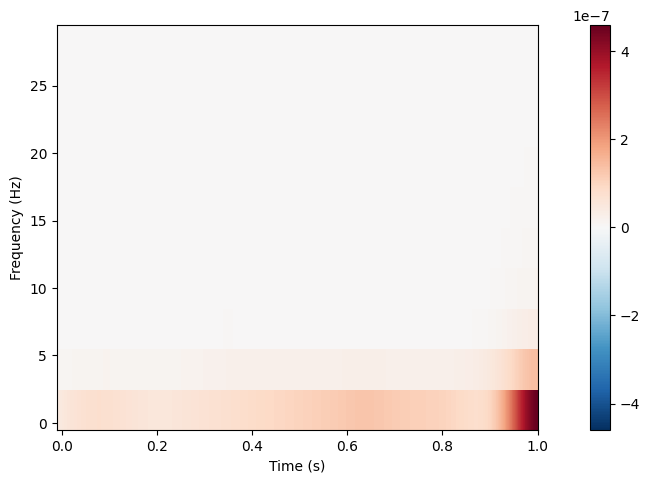

[<Figure size 640x480 with 2 Axes>]

In [11]:
power.plot([0])

In [12]:
power

<Average Power Estimates from Epochs (nave=900), morlet method | 124 channels × 10 freqs × 1035 times, 1.0 - 28.0 Hz, -0.01 - 1.00 s, 10.0 MB>

In [38]:
imagLables= np.array([0 for i in range(imagination.shape[0])])
perceptionLabels = np.array([1 for i in range(imagination.shape[0])])
labels = np.concatenate((imagLables, perceptionLabels), axis=0)
X = np.concatenate((imagination, perception), axis=0)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2],1)
labels.shape, X.shape

((900,), (900, 124, 1035, 1))

In [46]:

input_shape = (X.shape[1], X.shape[2], X.shape[3]) 

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    
    # Second convolutional layer
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Third convolutional layer
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Flatten the output
    #model.add(Flatten())
    
    # LSTM layer
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dropout(0.5))
    
    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_cnn_lstm_model(input_shape)
model.summary()



ValueError: Input 0 of layer "lstm_3" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 13, 127, 128)

In [29]:
X.shape, labels.shape

((900, 124, 1035, 1), (900,))

In [32]:

X = X.astype('float32')/np.max(X)
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train.shape, X_val.shape


((720, 124, 1035, 1), (180, 124, 1035, 1))

In [33]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=25,  validation_data=(X_val, y_val))


Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4813 - loss: 0.6992 - val_accuracy: 0.4778 - val_loss: 0.6932
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4938 - loss: 0.6931 - val_accuracy: 0.4778 - val_loss: 0.6932
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5116 - loss: 0.6931 - val_accuracy: 0.4778 - val_loss: 0.6934
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5266 - loss: 0.6928 - val_accuracy: 0.4778 - val_loss: 0.6935
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4951 - loss: 0.6932 - val_accuracy: 0.4778 - val_loss: 0.6935
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5097 - loss: 0.6931 - val_accuracy: 0.4778 - val_loss: 0.6935
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4907 - loss: 0.6934 - val_accuracy: 0.4778 - val_loss: 0.6934
Epoch 8/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5114 - loss: 0.6932

KeyboardInterrupt: 

In [4]:
def plotErpPerceptionAndImagination(filepath):
    data = mne.io.read_raw_fif(filepath, preload=True, verbose=False)
    events = mne.events_from_annotations(data)
    cleanedEvents = perceptionAndImaginationEvents(events)
    newEventId = {'Perception':1, 'Imagination':2}
    epochs = mne.Epochs(data.copy(), cleanedEvents, event_id=newEventId, tmin=-0.2, tmax=1.0)

    perception = epochs['Perception'].average()
    imagination = epochs['Imagination'].average()
    
    perceptionFigure = perception.plot_joint([0.1,  0.3, 0.5, 0.73]);
    imaginationFigure = imagination.plot_joint([0.1,  0.3, 0.5, 0.73]);

    perceptionFigure.savefig('perceptionERP.png', dpi = 600)
    imaginationFigure.savefig('imaginationERP.png', dpi = 600)

In [42]:
plotErpPerceptionAndImagination(filepath)

: 

In [24]:
newEventId = {'Perception':1, 'Imagination':2}
epochs = mne.Epochs(data.copy(), cleanedEvents, event_id=newEventId, tmin=-0.2, tmax=1.0)

Not setting metadata
900 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [25]:
perception = epochs['Perception'].average()
imagination = epochs['Imagination'].average()


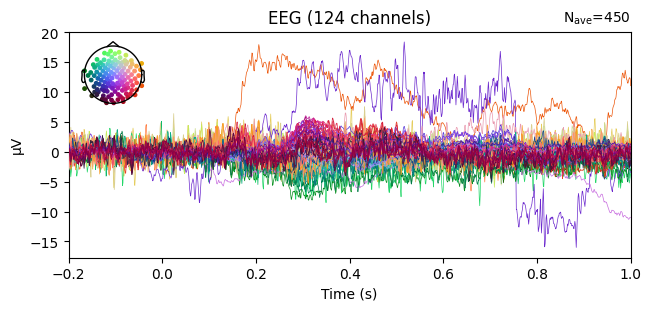

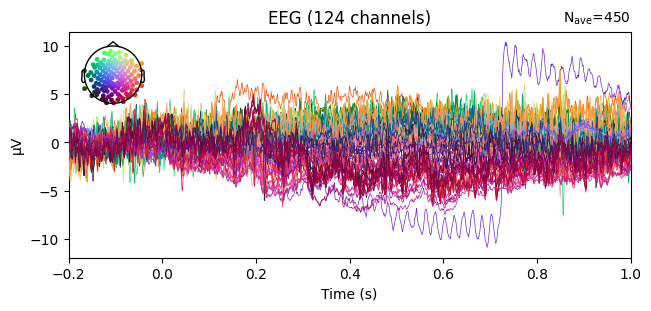

In [27]:
perImage = perception.plot();
imagImage = imagination.plot();

In [85]:
perImage.savefig('Perception.png', dpi=600)
imagImage.savefig('imagination.png', dpi=600)

In [28]:
# Find peak amplitude and latency for each condition
peak1, latency1 = perception.get_peak(tmin=0, tmax=0.5, return_amplitude=True)
peak2, latency2 = imagination.get_peak(tmin=0, tmax=0.5, return_amplitude=True)

print(f"Peak amplitude for eventType1: {peak1} uV at latency {latency1} seconds")
print(f"Peak amplitude for eventType2: {peak2} uV at latency {latency2} seconds")

amplitude_difference = peak1 - peak2
print(f"Amplitude difference between eventType1 and eventType2: {amplitude_difference} uV")


ValueError: too many values to unpack (expected 2)

In [87]:
from scipy import stats

# Extract data for statistical comparison
data1 = perception.data.squeeze()  # Squeeze removes unnecessary dimensions
data2 = imagination.data.squeeze()

# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(data1, data2)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between eventType1 and eventType2.")
else:
    print("No significant difference found between eventType1 and eventType2.")


T-statistic: [ 1.23415308e-08 -1.83279689e-08  1.55391431e-08 ... -8.84099878e-09
  1.17892023e-08  9.77417031e-09]
P-value: [0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Using data from preloaded Raw for 450 events and 1230 original time points ...
0 bad epochs dropped
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated


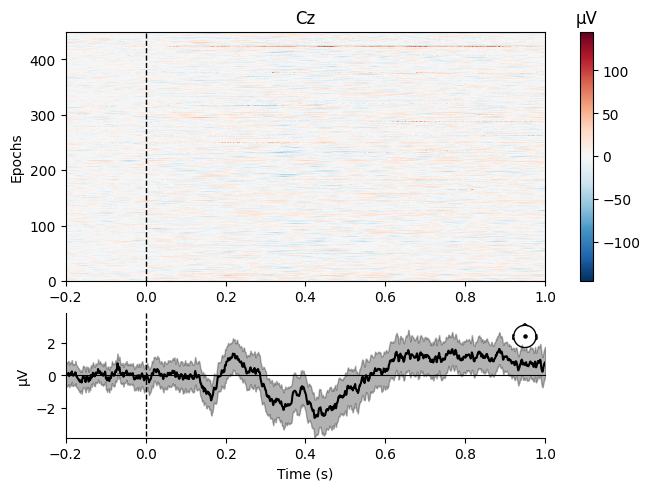

[<Figure size 640x480 with 4 Axes>]

In [32]:
epochs['Perception'].plot_image(picks=[15])

Using data from preloaded Raw for 450 events and 1230 original time points ...
0 bad epochs dropped
Not setting metadata
450 matching events found
No baseline correction applied
0 projection items activated


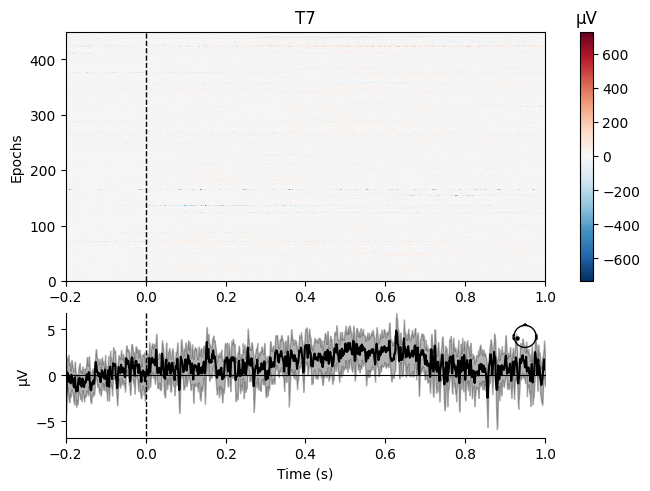

[<Figure size 640x480 with 4 Axes>]

In [33]:
epochs['Imagination'].plot_image(picks=[13])

In [34]:
epochs.equalize_event_counts(newEventId)

Using data from preloaded Raw for 900 events and 1230 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 


(<Epochs |  900 events (all good), -0.200195 – 1 s, baseline -0.200195 – 0 s, ~146 kB, data not loaded,
  'Perception': 450
  'Imagination': 450>,
 array([], dtype=int64))

No projector specified for this dataset. Please consider the method self.add_proj.


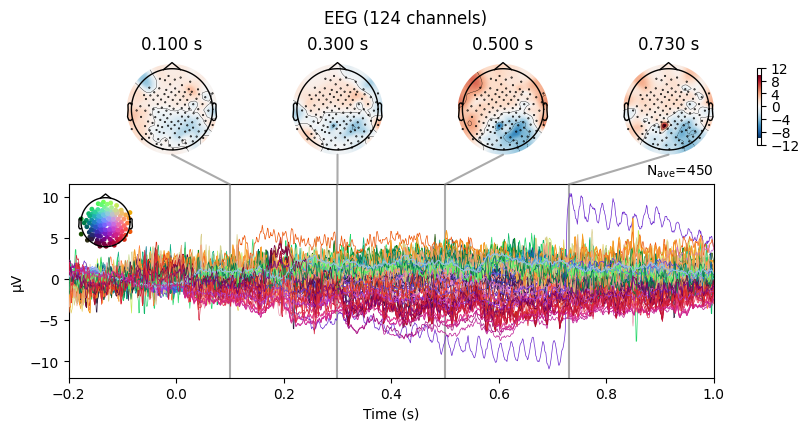

In [37]:
imagination.plot_joint([0.1,  0.3, 0.5, 0.73]);

No projector specified for this dataset. Please consider the method self.add_proj.


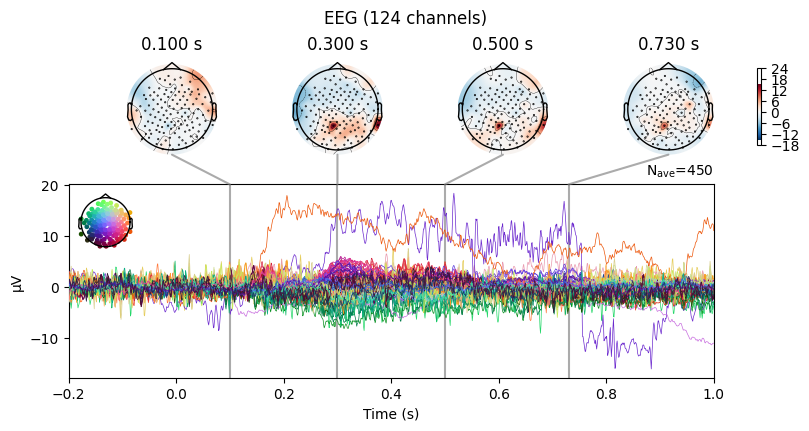

In [39]:
perception.plot_joint([0.1,  0.3, 0.5, 0.73]);

No projector specified for this dataset. Please consider the method self.add_proj.


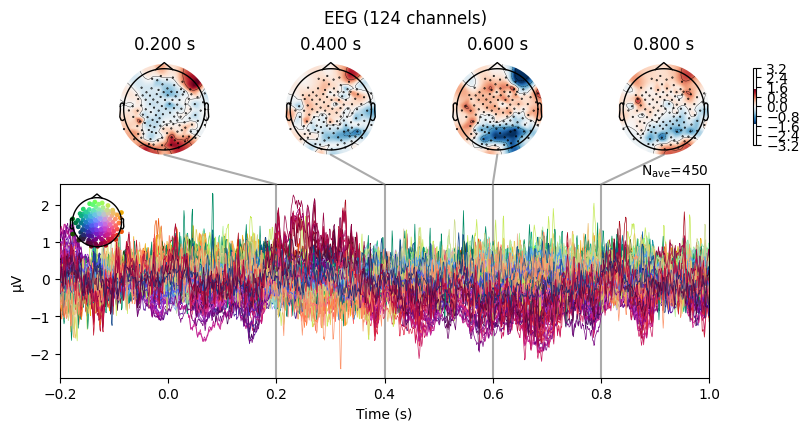

In [110]:
import matplotlib.pyplot as plt

# Generate the plot using plot_joint()
fig = imagination.plot_joint([0.2, 0.4, 0.6, 0.8])

# Customize text properties for each axis
for ax in fig.axes:
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(12)
    ax.xaxis.label.set_color('blue')
    ax.yaxis.label.set_color('green')
    ax.title.set_fontsize(5)
    ax.title.set_color('black')
    ax.tick_params(axis='both', which='major', labelsize=10, labelcolor='gray')

# Show the customized plot
plt.show()


No projector specified for this dataset. Please consider the method self.add_proj.


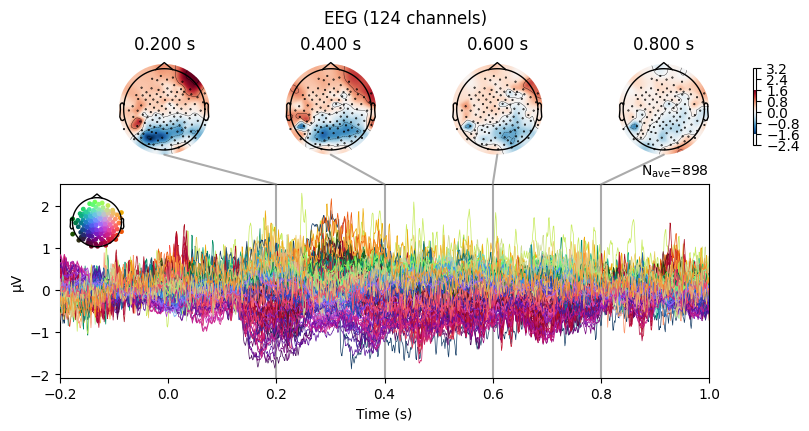

In [113]:
diff = mne.combine_evoked((imagination, - perception), weights='equal')
diff.plot_joint(times = [0.2,0.4, 0.6, 0.8]);

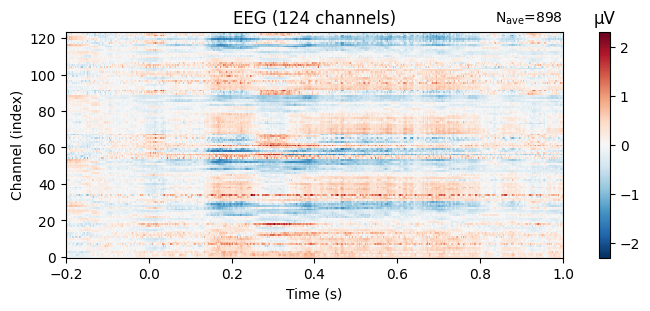

In [114]:
diff.plot_image();

In [5]:
triggersTimestamps = data[0][1]['time_stamps']
triggers = data[0][1]['time_series']
len(triggersTimestamps), len(triggers)

(5322, 5322)

In [6]:
audio = data[0][3]['time_series']
audioTimestamps = data[0][3]['time_stamps']
eegData = data[0][2]['time_series']
eegTimestamps = data[0][2]['time_stamps']
audio.shape, audioTimestamps.shape, eegData.shape

((183075840, 1), (183075840,), (3814127, 64))

In [7]:
triggers = np.array(triggers)
audio = audio.reshape(-1)
triggers = triggers.reshape(-1)
triggers.shape, audio.shape

((5322,), (183075840,))

In [8]:
def getActivity(activity):
    if 'Fixation' in activity:
        return 'Fixation'
    elif 'ITI' in activity:
        return 'ITI'
    elif 'ISI' in activity:
        return 'ISI'
    elif 'Speech' in activity:
        return 'Speech'
    elif 'Stimulus' in activity:
        return 'Stimulus'
    else:
        return 'None'

In [9]:
triggers[:20]

array(['SilentSyllablesPracticeStartFixation:Text_silence',
       'SilentSyllablesPracticeEndFixation:Text_silence',
       'SilentSyllablesPracticeStartStimulus:Text_silence',
       'SilentSyllablesPracticeEndStimulus:Text_silence',
       'SilentSyllablesPracticeStartISI:Text_silence',
       'SilentSyllablesPracticeEndISI:Text_silence',
       'SilentSyllablesPracticeStartSpeech:Text_silence',
       'SilentSyllablesPracticeEndSpeech:Text_silence',
       'SilentSyllablesPracticeStartITI:Text_silence',
       'SilentSyllablesPracticeEndITI:Text_silence',
       'SilentSyllablesPracticeStartFixation:Audio_CLO',
       'SilentSyllablesPracticeEndFixation:Audio_CLO',
       'SilentSyllablesPracticeStartStimulus:Audio_CLO',
       'SilentSyllablesPracticeEndStimulus:Audio_CLO',
       'SilentSyllablesPracticeStartISI:Audio_CLO',
       'SilentSyllablesPracticeEndISI:Audio_CLO',
       'SilentSyllablesPracticeStartSpeech:Audio_CLO',
       'SilentSyllablesPracticeEndSpeech:Audio_CLO',


In [10]:

def findClosestIndex(timepoints, target):
   
    timepoints = np.asarray(timepoints)  # Ensure the input is a NumPy array
    idx = np.searchsorted(timepoints, target, side="left")
    if idx == 0:
        return 0
    if idx == len(timepoints):
        return len(timepoints) - 1
    
    before = idx - 1
    after = idx
    
    if after < len(timepoints) and abs(timepoints[after] - target) < abs(timepoints[before] - target):
        return after, timepoints[before]
    else:
        return before, timepoints[after]


In [11]:
activity = None
task = None
word = None
mappings = []
for index in range(0, triggers.shape[0], 2):
    activity, action = triggers[index].split(':')
    task, word = action.split('_')
    activity = getActivity(activity)
    markerStartTime = triggersTimestamps[index]
    markerEndTime = triggersTimestamps[index+1]
    audioStartIndex, audioStartTime = findClosestIndex(audioTimestamps, markerStartTime)
    audioEndIndex, audioEndTime = findClosestIndex(audioTimestamps, markerEndTime)
    eegStartIndex, eegStartTime = findClosestIndex(eegTimestamps, markerStartTime)
    eegEndIndex, eegEndTime = findClosestIndex(eegTimestamps, markerEndTime)
    mappings.append([activity, task, word,
                    markerStartTime, markerEndTime,
                    eegStartTime, eegEndTime, eegStartIndex, eegEndIndex,
                    audioStartTime, audioEndTime, audioStartIndex, audioEndIndex     
                ])
 


In [14]:
eegSamplingFrequency = data[0][2]['info']['nominal_srate'][0]
audioSamplingFrequency = data[0][3]['info']['nominal_srate'][0]
audioSamplingFrequency

'48000.00000000000'

In [15]:
import os
from pathlib import Path
dataDir = Path(os.getcwd(), 'PilotData')

os.makedirs(dataDir, exist_ok=True)

In [16]:
import json
from scipy.io.wavfile import write

In [17]:
for index in range(len(mappings)):
    activity, task, word,
    activity, task, word, markerStartTime, markerEndTime, eegStartTime, eegEndTime, eegStartIndex, eegEndIndex, audioStartTime, audioEndTime, audioStartIndex, audioEndIndex = mappings[index] 
    filename = f'{activity}_{task}_{word}_{index}'
    audioFilenamPath = Path(dataDir, f'{filename}.wav')
    eegDataFilenamePath = Path(dataDir,f'{filename}.npy')
    jsonFilenamePath = Path(dataDir, f'{filename}.json')

    eegSample = eegData[eegStartIndex:eegEndIndex, ]
    audioSample =audio[audioStartIndex:audioEndIndex]
    
    jsonMetaData = {}
    jsonMetaData['Activity'] = activity
    jsonMetaData['task'] = task
    jsonMetaData['word'] = word
    jsonMetaData['MarkerStartTime'] = markerStartTime
    jsonMetaData['MarkerEndTime'] = markerEndTime
    jsonMetaData['EegStartTime'] = eegStartTime
    jsonMetaData['EegEndTime'] = eegEndTime
    jsonMetaData['EegStartIndex'] = str(eegStartIndex)
    jsonMetaData['EegEndIndex'] = str(eegEndIndex)
    jsonMetaData['audioStartTime'] = audioStartTime
    jsonMetaData['audioEndTime'] = audioEndTime
    jsonMetaData['audioStartIndex'] = str(audioStartIndex)
    jsonMetaData['audioEndIndex'] = str(audioEndIndex)
    jsonMetaData['EEGSamplingFrequency'] = eegSamplingFrequency
    jsonMetaData['AudioSamplingFrequency'] = audioSamplingFrequency

    with open(jsonFilenamePath, 'w') as jsonFile:
        json.dump(jsonMetaData, jsonFile, indent=4)
    np.save(eegDataFilenamePath, eegSample)
    write(audioFilenamPath, 48000, audioSample)
    
    

In [18]:
write('audio.wav', 48000, audio)